# Arthena Interview Task

## Question 1

### Section 1.1

<b> Column Assumptions </b>
Most relevant:  medium, date of execution, materials
Certain works by artists are more likely to be more valued than others. For example Picasso is most famous for his paintings, not his earthenware pieces. Similarly, certains eras in an artists life will be more popular. 
Least relevant:  Auction location, nth_lot_in_auction
Items in auctions are most normally announced ahead of time, so buyers will know which lots they want to spend money on

<b> Categorial and Currency Features </b>
Categorical features will be encoded as one-hot vectors, and for consistency all currencies will be converted into USD based on historical exchange rates. 

<b> Time Variance and IID data </b>
Given that this data is a time series, we cannot assume that the data is IID. This means that we will have to take special care in our modeling to account for this

### Section 1.2

In this section I begin first by doing some exploratory data analysis 

In [113]:
from forex_python.converter import CurrencyRates
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


In [154]:
picasso = pd.read_csv('artists/pablo_picasso.csv')

In [155]:
picasso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 0 to 7305
Data columns (total 24 columns):
work_title            7301 non-null object
medium                7306 non-null object
materials             7306 non-null object
submaterials          7306 non-null object
structure             7306 non-null object
date_of_execution     7306 non-null int64
artist                7306 non-null object
artist_nationality    7306 non-null object
artist_birth_year     7306 non-null int64
artist_death_year     7306 non-null int64
auction_sale_id       7306 non-null object
auction_house         7306 non-null object
auction_lot_count     7306 non-null int64
auction_location      7306 non-null object
auction_date          7306 non-null object
nth_lot_in_auction    7306 non-null int64
lot_description       7306 non-null object
currency              7306 non-null object
hammer_price          7306 non-null int64
estimate_low          7306 non-null int64
estimate_high         7306 non-null int6

In [156]:
picasso.describe()

,date_of_execution,artist_birth_year,artist_death_year,auction_lot_count,nth_lot_in_auction,hammer_price,estimate_low,estimate_high,height,width,depth
count,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7.306000e+03,7.306000e+03,7.306000e+03,7306.000000,7306.000000,7306.000000
mean,1607.068711,1879.454421,1971.378867,193.493019,64.113058,3.266596e+05,2.826244e+05,3.971199e+05,18.246485,17.633898,-0.465220
std,732.924929,53.914643,56.550215,156.989101,78.028423,2.110564e+06,1.803110e+06,2.383100e+06,81.154769,79.458124,9.601592
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000
25%,1925.000000,1881.000000,1973.000000,46.000000,-1.000000,4.200000e+03,3.500000e+03,5.000000e+03,-1.000000,-1.000000,-1.000000
50%,1952.000000,1881.000000,1973.000000,179.000000,34.000000,9.000000e+03,8.000000e+03,1.200000e+04,-1.000000,-1.000000,-1.000000
75%,1960.000000,1881.000000,1973.000000,309.000000,118.000000,4.000000e+04,3.000000e+04,4.500000e+04,-1.000000,-1.000000,-1.000000
max,2621.000000,1881.000000,1973.000000,990.000000,932.000000,6.000000e+07,6.000000e+07,6.000000e+07,749.000000,924.000000,654.000000


In [157]:
# first convert auciton date to datetime
import datetime
#df['DATE'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
picasso['auction_date'] = pd.to_datetime(picasso['auction_date'], format="%Y-%m-%d %H:%M:%S.%f")

#picasso['auction_date'] = picasso['auction_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [158]:
# to convert to currencies into USD, the following forex data will be used from 
# https://pkgstore.datahub.io/core/exchange-rates/daily_csv/data/03e15e28c7eea87026fee299a8859e97/daily_csv.csv
forex_data = pd.read_csv('forex.csv')
forex_data['Date'] = pd.to_datetime(forex_data['Date'])

In [159]:
# check names of currencies available
print(forex_data['Country'].unique())
print(picasso['currency'].unique())

['Australia' 'Brazil' 'Canada' 'China' 'Denmark' 'Euro' 'Hong Kong'
 'India' 'Japan' 'Malaysia' 'Mexico' 'New Zealand' 'Norway' 'Singapore'
 'South Africa' 'South Korea' 'Sweden' 'Switzerland' 'Taiwan' 'Thailand'
 'United Kingdom' 'Venezuela']
['GBP' 'USD' 'EUR' 'HKD' 'CNY']


In [160]:
# the currency name in forex_data is stored as the country name, changing to abbreviation
forex_data.loc[forex_data['Country'] == 'United Kingdom', 'Country'] = 'GBP'
forex_data.loc[forex_data['Country'] == 'China', 'Country'] = 'CNY'
forex_data.loc[forex_data['Country'] == 'Euro', 'Country'] = 'EUR'
forex_data.loc[forex_data['Country'] == 'Hong Kong', 'Country'] = 'HKD'

In [161]:
country_forex = forex_data.loc[forex_data['Country'].isin(['GBP', 'CNY', 'EUR', 'HKD'])]
picasso_with_forex = pd.merge(picasso, country_forex, left_on=['auction_date', 'currency'], right_on=['Date', 'Country'], how='left')

In [162]:
picasso_with_forex[['auction_date', 'Date', 'currency', 'Value']].head()

,auction_date,Date,currency,Value
0,2008-10-02 09:30:00.553,NaT,GBP,NaN
1,2018-03-28 00:00:00.000,NaT,GBP,NaN
2,2009-10-29 14:00:00.000,NaT,USD,NaN
3,2012-11-01 00:00:00.000,NaT,USD,NaN
4,2011-09-27 09:30:00.464,NaT,GBP,NaN


In [163]:
# fill in missing USD exchange rate Value with 1
picasso_with_forex.loc[picasso_with_forex['currency'] == 'USD', 'Value'] = 1

In [164]:
# now we can convert all hammer_price values to usd
picasso_with_forex['hammer_price_usd'] = 1/picasso_with_forex['Value'] * picasso_with_forex['hammer_price']

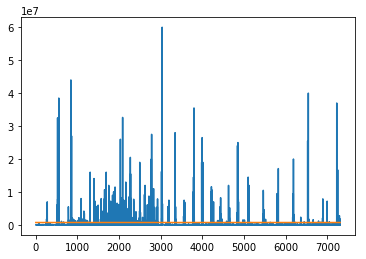

In [165]:
plt.plot(picasso[['hammer_price', 'auction_date']])

In [166]:
picasso[['auction_date']].head()

,auction_date
0,2008-10-02 09:30:00.553
1,2018-03-28 00:00:00.000
2,2009-10-29 14:00:00.000
3,2012-11-01 00:00:00.000
4,2011-09-27 09:30:00.464


In [167]:
picasso_with_forex.describe()

,date_of_execution,artist_birth_year,artist_death_year,auction_lot_count,nth_lot_in_auction,hammer_price,estimate_low,estimate_high,height,width,depth,Value,hammer_price_usd
count,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7.306000e+03,7.306000e+03,7.306000e+03,7306.000000,7306.000000,7306.000000,4607.000000,4.607000e+03
mean,1607.068711,1879.454421,1971.378867,193.493019,64.113058,3.266596e+05,2.826244e+05,3.971199e+05,18.246485,17.633898,-0.465220,0.918193,4.021018e+05
std,732.924929,53.914643,56.550215,156.989101,78.028423,2.110564e+06,1.803110e+06,2.383100e+06,81.154769,79.458124,9.601592,0.147415,2.368429e+06
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,0.504400,-1.685204e+00
25%,1925.000000,1881.000000,1973.000000,46.000000,-1.000000,4.200000e+03,3.500000e+03,5.000000e+03,-1.000000,-1.000000,-1.000000,0.940300,4.750000e+03
50%,1952.000000,1881.000000,1973.000000,179.000000,34.000000,9.000000e+03,8.000000e+03,1.200000e+04,-1.000000,-1.000000,-1.000000,1.000000,9.767092e+03
75%,1960.000000,1881.000000,1973.000000,309.000000,118.000000,4.000000e+04,3.000000e+04,4.500000e+04,-1.000000,-1.000000,-1.000000,1.000000,4.200000e+04
max,2621.000000,1881.000000,1973.000000,990.000000,932.000000,6.000000e+07,6.000000e+07,6.000000e+07,749.000000,924.000000,654.000000,1.000000,6.000000e+07


In [168]:
picasso_data = picasso_with_forex.loc[picasso_with_forex['hammer_price_usd'] > 0, :]

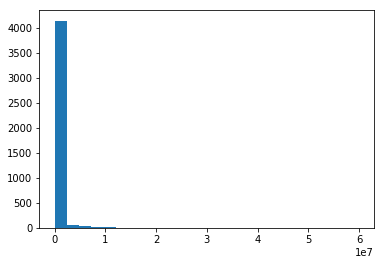

In [169]:
_ = plt.hist(picasso_data['hammer_price_usd'], bins=25)

In [170]:
# note that the spacing of the time series is uneven
np.sort(picasso_data['auction_date'].unique())

array(['2008-02-07T00:00:00.000000000', '2008-02-13T15:00:00.000000000',
       '2008-02-14T00:00:00.000000000', '2008-04-02T00:00:00.000000000',
       '2008-04-29T00:00:00.000000000', '2008-05-01T14:00:00.000000000',
       '2008-05-06T00:00:00.000000000', '2008-05-07T00:00:00.000000000',
       '2008-05-07T23:00:00.000000000', '2008-05-08T14:00:00.000000000',
       '2008-05-21T00:00:00.000000000', '2008-06-05T00:00:00.000000000',
       '2008-06-10T00:00:00.000000000', '2008-07-31T00:00:00.000000000',
       '2008-10-07T14:00:00.000000000', '2008-10-28T00:00:00.000000000',
       '2008-10-30T14:00:00.000000000', '2008-11-04T00:00:00.000000000',
       '2008-11-05T15:00:00.000000000', '2008-11-06T00:00:00.000000000',
       '2008-11-07T00:00:00.000000000', '2008-11-23T00:00:00.000000000',
       '2008-12-02T00:00:00.000000000', '2009-02-05T00:00:00.000000000',
       '2009-02-12T15:00:00.000000000', '2009-04-28T00:00:00.000000000',
       '2009-04-29T00:00:00.000000000', '2009-04-30

The problem here is that our time series data is not evenly spaced. Since many time series models rely on evenly spaced data (for lags, etc.), if I wanted to use one here, I would first have to interpolate the data and then resample at even intervals. However, this could introduce significant bias into the data, which is undesireable for modeling purposes. Given the uneven nature of the data, I am not inclined to use such a method. If I am to use a machine learning model here, there are some considerations that will need to be made. 

A time series model is generally of the form $x_t=ax_{t-1}+b$, meaning that the variable of interest has some kind of time dependency, i.e. its value is informed by previous values. To use a machine learning model with time series data, we must reformat the data to somehow incorporate information about this time dependency. There are two options I can see to do this. The first is to lag the data:  for a particular $y_t$, the features will be $X_{t-1}$ and $y_{t-1}$. This will create a dataset that features the time dependence that a time series attempts to model. The second method would be to encode the date data (here the feature "auction_date") as different features based on the year, month, and day of the date. This will introduce a time element into the feature space (much as how one would encode a categorical variable as a one hot vector). 

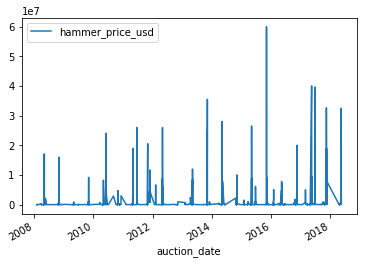

In [171]:
picasso_data.plot.line('auction_date', 'hammer_price_usd')

In [172]:
picasso_data = picasso_data.sort_values(['auction_date', 'nth_lot_in_auction'])
picasso_data.loc[:, 'auction_date':].head(n=5)

,auction_date,nth_lot_in_auction,lot_description,currency,hammer_price,estimate_low,estimate_high,height,width,depth,Date,Country,Value,hammer_price_usd
3731,2008-02-07,184,"PABLO PICASSO Le Saltimbanque au repos, from ...",USD,3500,3000,5000,448.0,324.0,-1.0,NaT,NaN,1.0,3500.0
3717,2008-02-07,185,PABLO PICASSO Nu assis entouré d'esquisses de...,USD,5500,3000,5000,-1.0,-1.0,-1.0,NaT,NaN,1.0,5500.0
3703,2008-02-07,186,PABLO PICASSO Colombe volant (B. 712; Mourlot...,USD,2200,1500,2500,-1.0,-1.0,-1.0,NaT,NaN,1.0,2200.0
3675,2008-02-07,187,PABLO PICASSO La famille du Saltimbanque (B. ...,USD,7500,6000,8000,502.0,654.0,-1.0,NaT,NaN,1.0,7500.0
3653,2008-02-07,188,"PABLO PICASSO Fernand Mourlot, Picasso lithog...",USD,1800,1500,2500,320.0,245.0,-1.0,NaT,NaN,1.0,1800.0


Examining the data, I note that there are multiple instances of auctions in a single day. There is also a variable 'nth_lot_in_auction', which gives us a sorted structure for the data. Reformatting the dataset as a lagged dataset as described above would help to mimic the nature of time series data, however given that the timesteps here are uneven, determining the proper lag introduces more complexity in the model. Given time constraints on this exercise, we proceed by incorporating time as features in the dataset. This gives us some ordering information in the dataset, which along with the 'nth_lot_in_auction' variable helps to introduce some temporal structure in the data. 

In [173]:
picasso_data['auction_year'] = pd.to_numeric(picasso_data['auction_date'].dt.year)
picasso_data['auction_month'] = pd.to_numeric(picasso_data['auction_date'].dt.month)
picasso_data['auction_day'] = pd.to_numeric(picasso_data['auction_date'].dt.day)

In [174]:
picasso_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4303 entries, 3731 to 7018
Data columns (total 31 columns):
work_title            4298 non-null object
medium                4303 non-null object
materials             4303 non-null object
submaterials          4303 non-null object
structure             4303 non-null object
date_of_execution     4303 non-null int64
artist                4303 non-null object
artist_nationality    4303 non-null object
artist_birth_year     4303 non-null int64
artist_death_year     4303 non-null int64
auction_sale_id       4303 non-null object
auction_house         4303 non-null object
auction_lot_count     4303 non-null int64
auction_location      4303 non-null object
auction_date          4303 non-null datetime64[ns]
nth_lot_in_auction    4303 non-null int64
lot_description       4303 non-null object
currency              4303 non-null object
hammer_price          4303 non-null int64
estimate_low          4303 non-null int64
estimate_high         4303 no

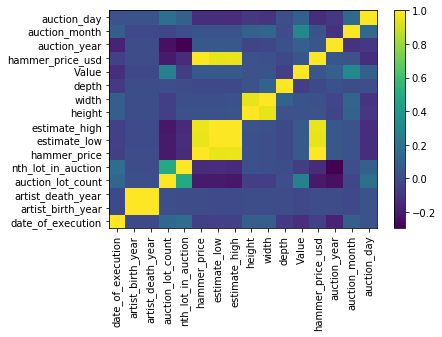

In [175]:
# now let's do some EDA to look at our variables
picasso_corr = picasso_data.corr()
plt.pcolor(picasso_corr)
plt.xticks(np.arange(0.5, len(picasso_corr.columns), 1), picasso_corr.columns, rotation='vertical')
plt.yticks(np.arange(0.5, len(picasso_corr.index), 1), picasso_corr.index)
plt.colorbar()
plt.figure(figsize=(50,50))
plt.show()

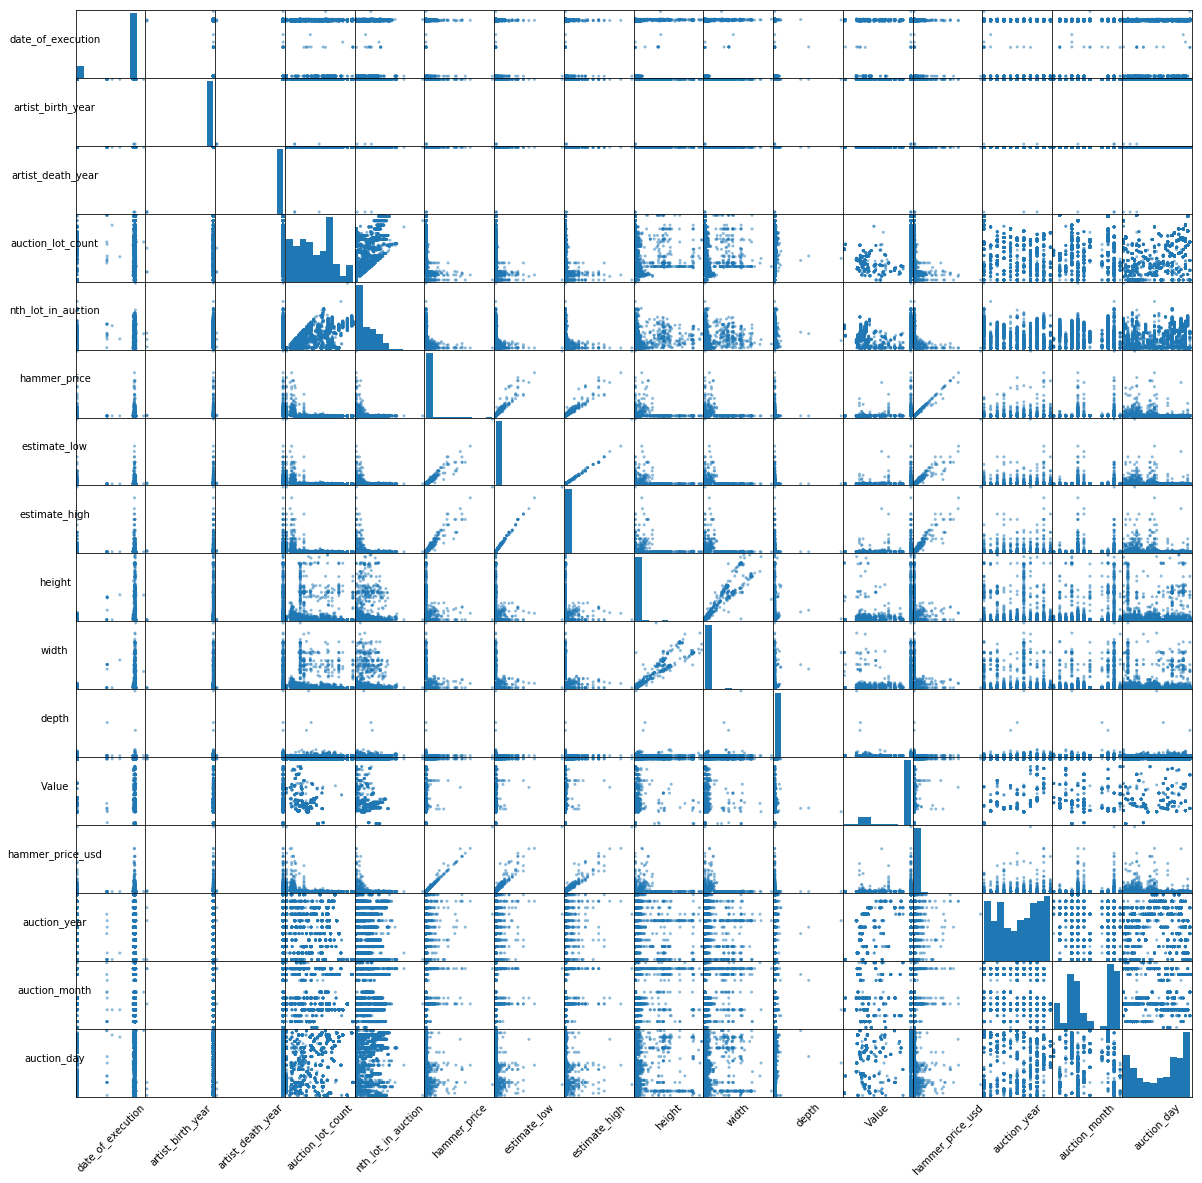

In [176]:
_ = pd.plotting.scatter_matrix(picasso_data, figsize=(20, 20))

# this formatting code taken from 
# https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles/32568134
v1 = [s.xaxis.label.set_rotation(45) for s in _.reshape(-1)]
v2 = [s.yaxis.label.set_rotation(0) for s in _.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
v3 = [s.get_yaxis().set_label_coords(-0.3,0.5) for s in _.reshape(-1)]

# Hide all ticks
v4 = [s.set_xticks(()) for s in _.reshape(-1)]
v5 = [s.set_yticks(()) for s in _.reshape(-1)]

These two plots show that there aren't many obvious relationships in the data, aside from esimates and hammer prices. This suggests non-linearity in the data.

In [177]:
picasso_data.describe()

,date_of_execution,artist_birth_year,artist_death_year,auction_lot_count,nth_lot_in_auction,hammer_price,estimate_low,estimate_high,height,width,depth,Value,hammer_price_usd,auction_year,auction_month,auction_day
count,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4.303000e+03,4.303000e+03,4.303000e+03,4303.000000,4303.000000,4303.000000,4303.000000,4.303000e+03,4303.000000,4303.000000,4303.000000
mean,1640.853126,1879.687892,1971.623751,239.655124,73.895189,4.101412e+05,3.407691e+05,4.849264e+05,26.112038,25.508634,-0.209691,0.913655,4.305097e+05,2012.742970,7.009296,17.605392
std,713.263855,49.681374,52.110007,152.529096,76.217079,2.351829e+06,1.980484e+06,2.673114e+06,94.314602,93.302303,12.370907,0.150215,2.448186e+06,3.120236,3.251993,10.156332
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.800000e+02,1.000000e+02,2.000000e+02,-1.000000,-1.000000,-1.000000,0.504400,5.000000e+02,2008.000000,1.000000,1.000000
25%,1933.000000,1881.000000,1973.000000,119.000000,-1.000000,5.000000e+03,4.000000e+03,6.000000e+03,-1.000000,-1.000000,-1.000000,0.878000,5.500000e+03,2010.000000,4.000000,7.000000
50%,1953.000000,1881.000000,1973.000000,235.000000,54.000000,1.000000e+04,8.000000e+03,1.200000e+04,-1.000000,-1.000000,-1.000000,1.000000,1.100000e+04,2013.000000,6.000000,21.000000
75%,1961.000000,1881.000000,1973.000000,361.000000,131.000000,4.500000e+04,3.000000e+04,5.000000e+04,-1.000000,-1.000000,-1.000000,1.000000,4.800000e+04,2016.000000,10.000000,27.000000
max,2250.000000,1881.000000,1973.000000,576.000000,527.000000,6.000000e+07,6.000000e+07,6.000000e+07,749.000000,924.000000,654.000000,1.000000,6.000000e+07,2018.000000,12.000000,31.000000


In [178]:
picasso_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4303 entries, 3731 to 7018
Data columns (total 31 columns):
work_title            4298 non-null object
medium                4303 non-null object
materials             4303 non-null object
submaterials          4303 non-null object
structure             4303 non-null object
date_of_execution     4303 non-null int64
artist                4303 non-null object
artist_nationality    4303 non-null object
artist_birth_year     4303 non-null int64
artist_death_year     4303 non-null int64
auction_sale_id       4303 non-null object
auction_house         4303 non-null object
auction_lot_count     4303 non-null int64
auction_location      4303 non-null object
auction_date          4303 non-null datetime64[ns]
nth_lot_in_auction    4303 non-null int64
lot_description       4303 non-null object
currency              4303 non-null object
hammer_price          4303 non-null int64
estimate_low          4303 non-null int64
estimate_high         4303 no

In [179]:
# given the above relationships plotted, I'm going to select the following numerical variables for the model
numerical_attr = ['date_of_execution', 'auction_lot_count', 'nth_lot_in_auction', 'estimate_low', 'estimate_high', 
                  'height', 'width', 'depth', 'auction_year', 'auction_month', 'auction_day']

# and these categorical attributes
categorical_attr = ['medium', 'materials', 'submaterials', 'structure', 'auction_house', 'auction_location']

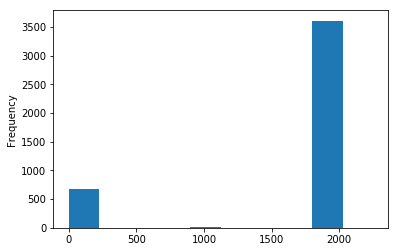

In [180]:
# further data cleaning

# I noticed that some values in the 'execution_date' column were weird, I want to see what the distribution of these values is
picasso_data['date_of_execution'].plot.hist()

In [181]:
# Some of these dates either do not exist or are wrong. Since most of the data seems to be in a reasonable time frame, 
# I will impute the entries less than 1881, the year Picasso was born, to the value nan
picasso_data.loc[picasso_data['date_of_execution'] < 1881, 'date_of_execution'] = np.nan

In [182]:
# several other of the numerical values have negative numbers, these will be changed to nan and imputed later
# these -1 values indicate that the value is missing
picasso_data[picasso_data[numerical_attr] < 0] = np.nan

In [183]:
# now I encode my one-hot vector
cat_encoded_df = pd.get_dummies(picasso_data[categorical_attr])
col_names = [c for c in cat_encoded_df.columns if c.lower()[-1] != '1']
cat_encoded_df = cat_encoded_df[col_names]

In [184]:
num_df = picasso_data[numerical_attr]
total_data = num_df.join(cat_encoded_df)

In [185]:
# do divide into the train and data set, I will use 80% of the data for the train set
# as this is a time series problem, we cannot randomly sample our data for these sets
# the hold out set must be future data relative to the training data
train_index = int(0.8 * len(total_data))
train_data = total_data.iloc[:train_index, :]
test_data = total_data.iloc[train_index:, :]

In [186]:
# preparing data for modeling with pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

In [205]:
# extract labels from each dataset
train_target = picasso_data.iloc[:train_index, :]['hammer_price_usd']
test_target = picasso_data.iloc[train_index:, :]['hammer_price_usd']

In [189]:
processed_training_data = num_pipeline.fit_transform(train_data)

In [190]:
processed_test_data = num_pipeline.transform(test_data)

In [215]:
random_seed = 42

In [223]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=500, random_state=random_seed)
random_forest.fit(processed_training_data, train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [324]:
part1_predictions = random_forest.predict(processed_test_data)

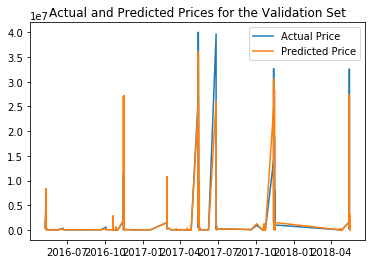

In [325]:
test_dates = picasso_data.iloc[train_index: , :]['auction_date']
plt.plot(test_dates, test_target, label='Actual Price')
plt.plot(test_dates, part1_predictions, label='Predicted Price')
plt.title('Actual and Predicted Prices for the Validation Set')
plt.legend()
plt.show()

In [326]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(test_target, part1_predictions))
mae = mean_absolute_error(test_target, part1_predictions)

print('Root Mean Squared Error on Validation Set: {}'.format(rms))
print('Mean Absolute Error on Validation Set: {}'.format(mae))

Root Mean Squared Error on Validation Set: 1410676.478023825
Mean Absolute Error on Validation Set: 255438.42253035022


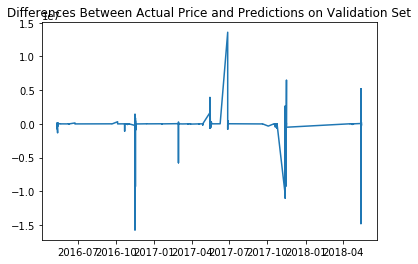

In [327]:
plt.plot(test_dates, test_target-part1_predictions)
plt.title('Differences Between Actual Price and Predictions on Validation Set')
plt.show()

#### Discussion

From the plots above, we can see that the model with temporal information is able to approximate the price series in the validation set. I chose to use a random forest model, to handle the nonlinear relationships suggested by the data in the scatter matrix and correlation plots. The random forest is additionally a good base model to use as it has good empirical performance on a wide range of problems. Categorical variables were dummy encoded, and any variable with redundant information (such as artist, or birth year) were eliminated as they did not add any new information. Data was standardized to make data scales consistent. 

### Section 1.3

<b>Model Validation</b>

Given that our data is a time series, we cannnot validate the model in the usual fashion, i.e. randomly sample the dataset to create the traning and test sets. This is because our iid assumption does not hold as strongly with time series data. The model must be tested on a historical set and then used to forecast future prices, which means that the training set will be earlier time steps up to an index, and the test set will be those timesteps (in sequential order) after that time index. The time dependent nature of the data means that we cannot randomly sample data at random times, we must use the temportal nature of the data to validate. Additionally, as described above in section 1.2, I included time data as features in the dataset to help capture the time dependent nature of the original time series. 

<b>Error Metrics</b>
Three error metrics were used here:  two qualitative (RMSE and MAE), and one qualitative (plots). RMSE gives large weight to large errors, and as we can see from the predicted vs. actual plots, there are some large under estimations in the future series. I used MAE, which is the average absolute deviation, to have a more interpretable understanding of the predictions. I used plots to ensure that the model is modeling time series data well. From the model, the trends are followed closely meaning that the random forest here is somewhat efficacious. 

## Question 2

### Section 2.1

In this section, I will follow the same modeling scheme as above, using a random forest to predict Picasso price series. I do this to specifically compare how the same model trained on a broader dataset compares to the exercise above, i.e. to have more meaningful model comparisons. 

In [237]:
lewitt_csv = pd.read_csv('artists/sol_lewitt.csv')
warhol_csv = pd.read_csv('artists/andy_warhol.csv')
picasso_csv = pd.read_csv('artists/pablo_picasso.csv')

In [239]:
artists = pd.concat([lewitt_csv, warhol_csv, picasso_csv], ignore_index=True)

In [240]:
artist_df = artists.copy()

In [242]:
# adding forex data as above
artist_df['auction_date'] = pd.to_datetime(artist_df['auction_date'], format="%Y-%m-%d %H:%M:%S.%f")
artist_df = pd.merge(artist_df, country_forex, left_on=['auction_date', 'currency'], right_on=['Date', 'Country'], how='left')
# fill in missing USD exchange rate Value with 1
artist_df.loc[artist_df['currency'] == 'USD', 'Value'] = 1
# now we can convert all hammer_price values to usd
artist_df['hammer_price_usd'] = 1/artist_df['Value'] * artist_df['hammer_price']
# filter dataset to contain only those pieces that sold
artist_df = artist_df.loc[artist_df['hammer_price_usd'] > 0, :]

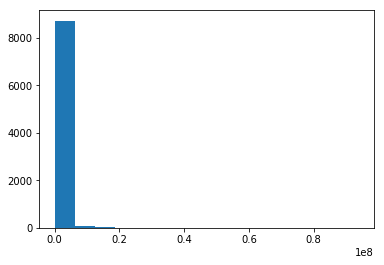

In [245]:
# plot a histogram of hammer_price_usd to visualize result
_ = plt.hist(artist_df['hammer_price_usd'], bins = 15)

In [248]:
# add in time data
artist_df['auction_year'] = pd.to_numeric(artist_df['auction_date'].dt.year)
artist_df['auction_month'] = pd.to_numeric(artist_df['auction_date'].dt.month)
artist_df['auction_day'] = pd.to_numeric(artist_df['auction_date'].dt.day)

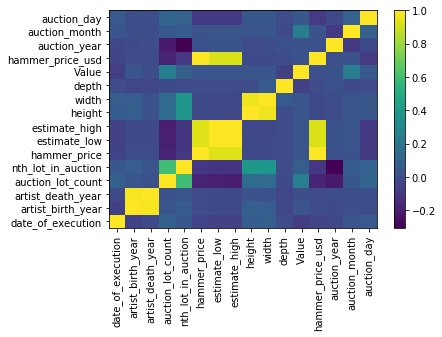

In [249]:
artist_corr = artist_df.corr()
plt.pcolor(artist_corr)
plt.xticks(np.arange(0.5, len(artist_corr.columns), 1), artist_corr.columns, rotation='vertical')
plt.yticks(np.arange(0.5, len(artist_corr.index), 1), artist_corr.index)
plt.colorbar()
plt.figure(figsize=(50,50))
plt.show()

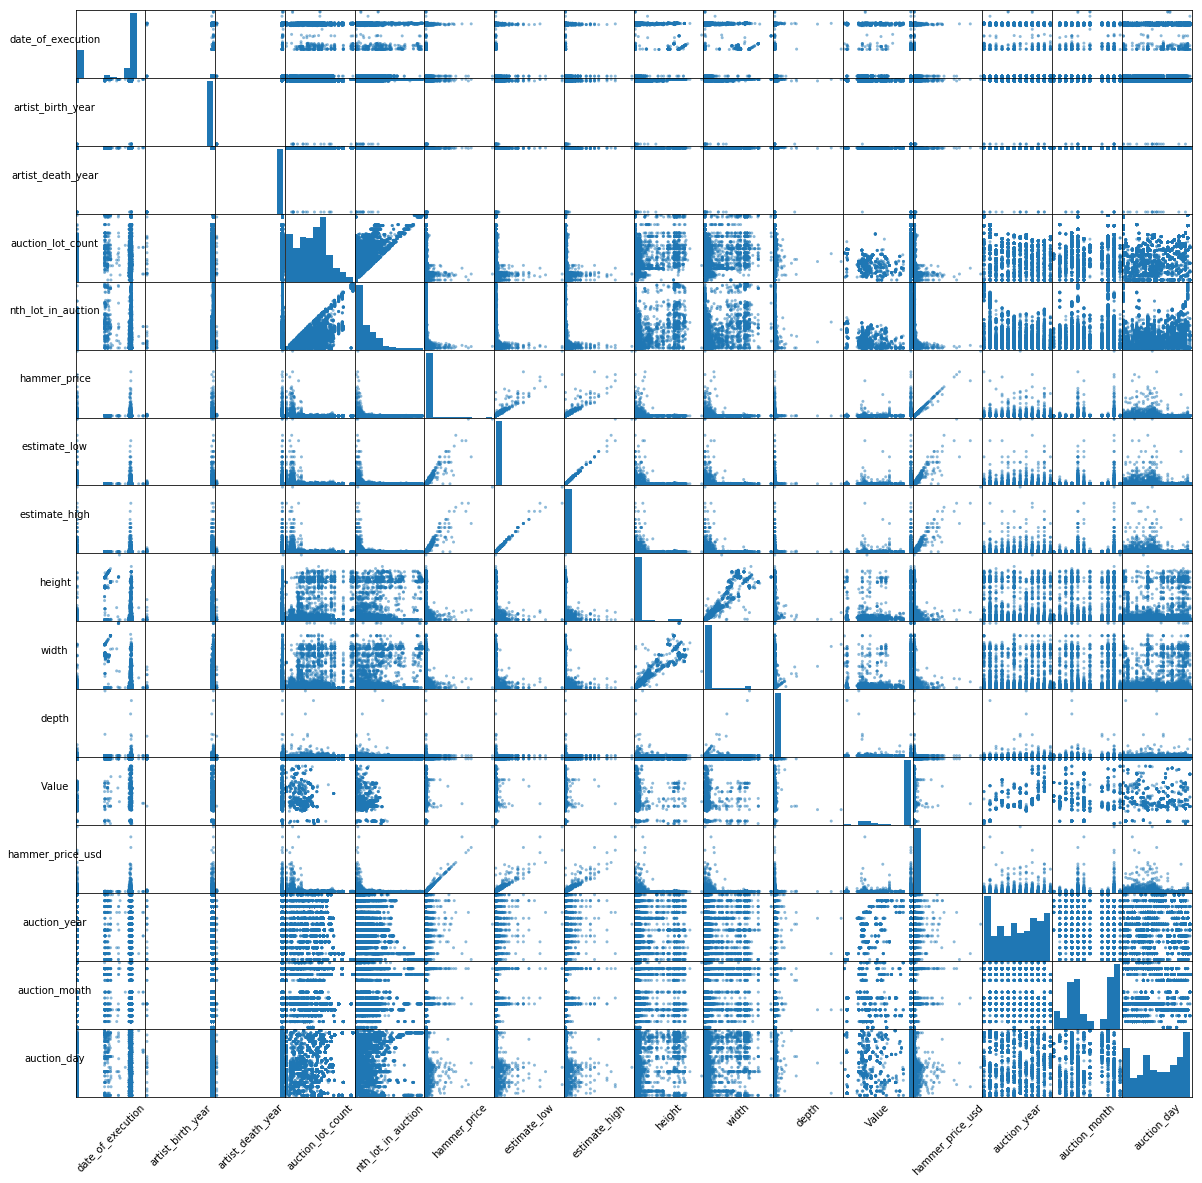

In [250]:
_ = pd.plotting.scatter_matrix(artist_df, figsize=(20, 20))

# this formatting code taken from 
# https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles/32568134
v1 = [s.xaxis.label.set_rotation(45) for s in _.reshape(-1)]
v2 = [s.yaxis.label.set_rotation(0) for s in _.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
v3 = [s.get_yaxis().set_label_coords(-0.3,0.5) for s in _.reshape(-1)]

# Hide all ticks
v4 = [s.set_xticks(()) for s in _.reshape(-1)]
v5 = [s.set_yticks(()) for s in _.reshape(-1)]

In [251]:
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8853 entries, 0 to 13730
Data columns (total 31 columns):
work_title            8837 non-null object
medium                8853 non-null object
materials             8853 non-null object
submaterials          8853 non-null object
structure             8853 non-null object
date_of_execution     8853 non-null int64
artist                8853 non-null object
artist_nationality    8853 non-null object
artist_birth_year     8853 non-null int64
artist_death_year     8853 non-null int64
auction_sale_id       8853 non-null object
auction_house         8853 non-null object
auction_lot_count     8853 non-null int64
auction_location      8853 non-null object
auction_date          8853 non-null datetime64[ns]
nth_lot_in_auction    8853 non-null int64
lot_description       8853 non-null object
currency              8853 non-null object
hammer_price          8853 non-null int64
estimate_low          8853 non-null int64
estimate_high         8853 non-

In [294]:
# in the above nothing immediately jumps out as a strange or abnormal relationship. likely indicates non-linear relationshiops

# choosing similar variables for the model
numerical_attr = ['date_of_execution', 'auction_lot_count', 'nth_lot_in_auction', 'estimate_low', 'estimate_high', 
                  'height', 'width', 'depth', 'auction_year', 'auction_month', 'auction_day']
other_attr = ['hammer_price_usd', 'auction_date']

# and these categorical attributes, adding artist as we now have more data variation
categorical_attr = ['medium', 'materials', 'submaterials', 'structure', 'auction_house', 'auction_location', 'artist']

In [252]:
artist_df.describe()

,date_of_execution,artist_birth_year,artist_death_year,auction_lot_count,nth_lot_in_auction,hammer_price,estimate_low,estimate_high,height,width,depth,Value,hammer_price_usd,auction_year,auction_month,auction_day
count,8853.000000,8853.000000,8853.000000,8853.000000,8853.000000,8.853000e+03,8.853000e+03,8.853000e+03,8853.000000,8853.000000,8853.000000,8853.000000,8.853000e+03,8853.000000,8853.000000,8853.000000
mean,1409.200158,1901.249972,1977.536541,258.810121,103.861968,4.167661e+05,3.372554e+05,4.775075e+05,100.911351,94.492181,0.055983,0.936972,4.386291e+05,2012.488196,7.161979,16.835084
std,864.924540,89.006619,89.821233,157.272210,127.850207,2.614377e+06,2.010856e+06,2.745654e+06,256.776559,240.534463,18.179659,0.134401,2.758214e+06,3.272425,3.217976,9.692197
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3.500000e+02,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,0.484400,5.000000e+02,2007.000000,1.000000,1.000000
25%,-1.000000,1881.000000,1973.000000,138.000000,-1.000000,7.000000e+03,5.000000e+03,7.000000e+03,-1.000000,-1.000000,-1.000000,1.000000,7.500000e+03,2010.000000,4.000000,9.000000
50%,1954.000000,1928.000000,1987.000000,273.000000,65.000000,1.900000e+04,1.500000e+04,2.000000e+04,-1.000000,-1.000000,-1.000000,1.000000,2.000000e+04,2013.000000,6.000000,17.000000
75%,1969.000000,1928.000000,1987.000000,365.000000,156.000000,7.000000e+04,5.000000e+04,7.000000e+04,49.600000,45.700000,-1.000000,1.000000,7.077697e+04,2015.000000,10.000000,26.000000
max,2431.000000,1928.000000,2007.000000,673.000000,652.000000,9.400000e+07,6.000000e+07,8.000000e+07,1543.000000,1518.000000,1016.000000,1.000000,9.400000e+07,2018.000000,12.000000,31.000000


(array([2.359e+03, 0.000e+00, 0.000e+00, 0.000e+00, 2.680e+02, 2.500e+01,
        1.100e+01, 7.810e+02, 5.404e+03, 5.000e+00]),
 array([-1.0000e+00,  2.4220e+02,  4.8540e+02,  7.2860e+02,  9.7180e+02,
         1.2150e+03,  1.4582e+03,  1.7014e+03,  1.9446e+03,  2.1878e+03,
         2.4310e+03]),
 <a list of 10 Patch objects>)

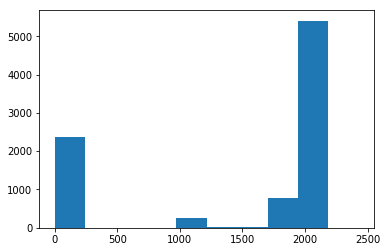

In [253]:
# examining date of execution, as this variable might provide useful modeling info, and seems to have some strange values 
plt.hist(artist_df['date_of_execution'])

In [254]:
# as above I will filter anything before 1881, the year picasso was born
artist_df.loc[artist_df['date_of_execution'] < 1881, 'date_of_execution'] = np.nan

In [256]:
# several other of the numerical values have negative numbers, these will be changed to nan and imputed later
# these -1 values indicate that the value is missing
artist_df[artist_df[numerical_attr] < 0] = np.nan

In [263]:
# now I encode my one-hot vector
cat_encoded_df = pd.get_dummies(artist_df[categorical_attr])
col_names = [c for c in cat_encoded_df.columns if c.lower()[-1] != '1']
cat_encoded_df = cat_encoded_df[col_names]

In [296]:
artist_num = artist_df[numerical_attr+other_attr]
total_artist_data = artist_num.join(cat_encoded_df)

In [297]:
total_artist_data.columns.values

array(['date_of_execution', 'auction_lot_count', 'nth_lot_in_auction',
       'estimate_low', 'estimate_high', 'height', 'width', 'depth',
       'auction_year', 'auction_month', 'auction_day', 'hammer_price_usd',
       'auction_date', 'medium_collage', 'medium_drawing',
       'medium_others', 'medium_painting', 'medium_photograph',
       'medium_print', 'materials_acrylic', 'materials_acrylic ink',
       'materials_acrylic ink oil', 'materials_acrylic oil',
       'materials_acrylic pastel ink oil', 'materials_aluminum',
       'materials_aluminum bronze', 'materials_aluminum enamel',
       'materials_bronze', 'materials_charcoal',
       'materials_charcoal collage ink', 'materials_charcoal gouache',
       'materials_charcoal ink', 'materials_charcoal oil',
       'materials_charcoal pastel', 'materials_charcoal pastel oil',
       'materials_collage', 'materials_collage gouache',
       'materials_collage gouache ink', 'materials_collage ink',
       'materials_collage oil', '

In [306]:
# data set creation

# to create the validation set, I will take the last 1000 (i.e. most recent) Picasso examples
no_picasso = total_artist_data[(total_artist_data['artist_Pablo Picasso']==0) & 
                               (total_artist_data['artist_Pablo Picasso (0']==0) &
                               (total_artist_data['artist_Pablo Picasso and Henri Laurens']==0)]
all_picasso = total_artist_data[(total_artist_data['artist_Pablo Picasso']==1) | 
                               (total_artist_data['artist_Pablo Picasso (0']==1) |
                               (total_artist_data['artist_Pablo Picasso and Henri Laurens']==1)].sort_values('auction_date')
train_picasso = all_picasso.iloc[:-1000, :]
test_picasso = all_picasso.iloc[-1000:, :]
test_dates = test_picasso['auction_date']

In [311]:
artist_train = pd.concat([no_picasso, all_picasso], ignore_index=True)
artist_train_target = artist_train['hammer_price_usd']
aritist_test_target = test_picasso['hammer_price_usd']


In [315]:
artist_train = artist_train.drop(labels=['hammer_price_usd', 'auction_date'], axis=1)
test_picasso = test_picasso.drop(labels=['hammer_price_usd', 'auction_date'], axis=1)

In [316]:
# now refit the previous numerical pipeline on training data
processed_artist_train = num_pipeline.fit_transform(artist_train)

In [317]:
# now transform test data
proessed_test_picasso = num_pipeline.transform(test_picasso)

In [318]:
random_seed = 42

In [319]:
from sklearn.ensemble import RandomForestRegressor

random_forest_all = RandomForestRegressor(n_estimators=500, random_state=random_seed)
random_forest_all.fit(processed_artist_train, artist_train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [320]:
predictions = random_forest_all.predict(proessed_test_picasso)

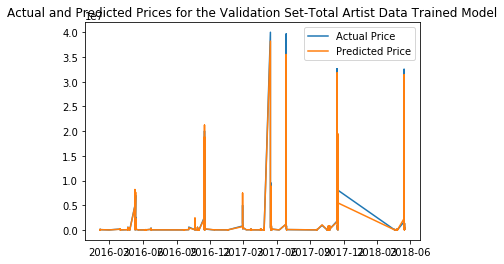

In [321]:
plt.plot(test_dates, aritist_test_target, label='Actual Price')
plt.plot(test_dates, predictions, label='Predicted Price')
plt.title('Actual and Predicted Prices for the Validation Set-Total Artist Data Trained Model')
plt.legend()
plt.show()

In [322]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(aritist_test_target, predictions))
mae = mean_absolute_error(aritist_test_target, predictions)

print('Root Mean Squared Error on Validation Set: {}'.format(rms))
print('Mean Absolute Error on Validation Set: {}'.format(mae))

Root Mean Squared Error on Validation Set: 271741.70432806923
Mean Absolute Error on Validation Set: 54667.354996797934


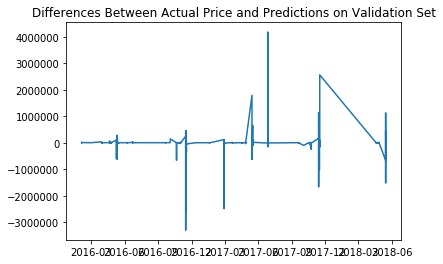

In [323]:
plt.plot(test_dates, aritist_test_target-predictions)
plt.title('Differences Between Actual Price and Predictions on Validation Set')
plt.show()

### Discussion

For the model only trained on the picasso data set had the following validation error metrics: 

Root Mean Squared Error on Validation Set: 1410676.478023825 <br>
Mean Absolute Error on Validation Set: 255438.42253035022

The model trained on the total dataset and only validated on the picasso set had the following error metrics:

Root Mean Squared Error on Validation Set: 271741.70432806923 <br>
Mean Absolute Error on Validation Set: 54667.354996797934

Training on a larger dataset drastically improved the model performance. The model still underestimates several large auction prices, but overall the result is improved. A pooled model here has the added benefit of more data, which allows the data set to learn a wider feature space and can help improve prediction accuracy. However, single artist models would model the dynamics of the auctions for those artists without any added effects from other artists. The auction dynamics for other artists (i.e. selling price, number of items for sale) may not be similar to an artist under consideration, and that data may not add relevant information, or even information that could reduce prediction accuracy.


### Section 2.2

Text(0.5,1,'Question 1 Predictions')

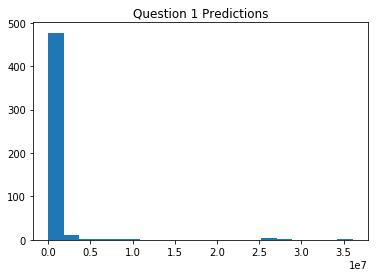

In [330]:
plt.hist(part1_predictions[:500], bins=20)
plt.title('Question 1 Predictions')

The predictions here are a skewed distrubtion, with extreme variance. Most of the predictions are clustered in lower bins, but given that some predictions are of much higher value, these model seems to have a large variance. Given this, the model will predict a wide range of hammer prices, and will likely be able to model some of the extreme prices seen well. Given that most of the prices were clustered in lower ranges, this model will likely predict many auction prices well. However, the skew towards lower prices may mean that the model will tend to underestimate prices, leading to less confidence in this model. 

Text(0.5,1,'Question 2 Predictions')

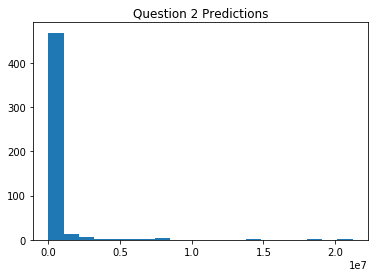

In [331]:
plt.hist(predictions[:500], bins=20)
plt.title('Question 2 Predictions')

Similar to the above distribution, the predictions here a large variance and most of the predictions are clustered in lower bins, where many auction prices do occur. This data here has less variance than the predictions in question one, but are similarly skewed towards lower values, meaning that this model will likely underestimate prices. 

### Section 2.3

In [332]:
pooled_feature_importances = random_forest_all.feature_importances_

In [334]:
features_names = artist_train.columns.values

In [337]:
ft_imp = pd.DataFrame({'Features':features_names, 'Importance':pooled_feature_importances})

In [340]:
ft_imp.sort_values('Importance', ascending=False).head(n=10)

,Features,Importance
3,estimate_low,0.472720
4,estimate_high,0.429530
6,width,0.024067
5,height,0.012100
8,auction_year,0.010439
10,auction_day,0.008908
2,nth_lot_in_auction,0.007416
1,auction_lot_count,0.007062
0,date_of_execution,0.003825
158,structure_linen,0.003151


Above we can see the ten most important features in the pooled random forest model. The estimates were the most important features for modeling, which makes sense given their strong correlation earlier. Width and height are also very important features, somewhat surprisingly-it may be that the imputation of the median introduced some relationship that the model was able to take advantage of. Auction year makes sense as an important feature, as well as the nth_lot_in_the_auction. Additionally, date_of_execution makes sense as an important feature, as certain years of an artists production produced more well-known work.

Given more data, it would be interesting to compute a "sentiment" feature by scraping tweets and news articles about art auctions. This could give an assessment about art world buzz for a particular piece that may help inform price.

# Questions

1) Assuming here that we have features + price. Given that we don't have very many features here, we could try to engineer some new ones. This could be done via a feature extraction method such as PCA, which would produce new features that could then be used for prediction. If the question is implying that we don't have price and we have to estimate price from those features, this would perhaps call for some external data research and finding of prices that works by the artist sold, and then information about those works. From this data set we could draw similarities between those works and the data that we have. Further, we could model a distribution of the works sold and use that to help make estimates of our data. 

2) Painting, prints, and drawings. Historically paintings have sold set auction records and will likely continue to be the record setters in art auctions. Additionally, works like these tend to be easier to move than works like sculptures, which may make a work hard to sell. 

3) An easy way to tackle this would be to modify the objective function to punish very large model estimates. This could be done by upweighting model estimates that have large positive deviations from the actual target. Assuming the model loss is driven by something like gradient descent, this would help to punish those large deviations that cause overestimates. Additionally, heavy regularization could be used to ensure that the model doesn't overfit, or a model with less variance could be used. 

4) One way in which these large auction houses do this is by emphasizing certain artists over others. By increasing demand (and also reducing supply by selling art) for works by particular artists, these auction houses increase the attention and focus on a particular set of artists. Given the limited supply of works by these artists, this can in turn drive up prices for these works, while leaving other artists relatively ignored (and maintaining these prices lower and less variable). 

5) By doing more tweaking of the parameters of the random forest model and checking validation accuracy. Additionally, more feature engineering would probably increase the accuracy of the model by encoding stronger relationships in the data. This could be done with PCA/ICA to help extract better signals from the data, or by manually. These methods can help to reduce noise in the variables by extracting more "meaningful" features. 

6) This was an interesting and challenging exercise. I think the first question gave me the most trouble, especially working out how to frame the time series data as a regression problem, especially given the nature of the data. Overall, a very fun exercise!